In [1]:
import os
import re
import h5py
import torch
import numpy as np

from tqdm import tqdm
from nltk import tokenize
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Dense, Input, Flatten, Dropout, merge, BatchNormalization
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional
from keras.layers.core import Reshape, RepeatVector
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# from keras.models import Model

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Convolution1D, MaxPooling1D
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

import torch
import numpy as np
from tensorflow.keras import Model
import tensorflow as tf


# from attention import Attention_input1, Attention_input2

from tensorflow.python.keras.layers import Layer, InputSpec
from keras import backend as K
from keras import initializers,regularizers,constraints
from sklearn.decomposition import PCA
# from keras.optimizers import SGD, RMSprop, Adagrad

In [2]:
# for loading saved output data
def load_mvsa_data(path):
    read_file = h5py.File(path, 'r')
    
    texts = read_file['texts'][:]
    texts = np.array([x.decode('UTF-8') for x in texts]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
    images = read_file['images'][:]
    
    multimodal_labels = read_file['multimodal-labels'][:]
    multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels])

    text_labels = read_file['text-labels'][:]
    text_labels = np.array([x.decode('UTF-8') for x in text_labels])

    image_labels = read_file['image-labels'][:]
    image_labels = np.array([x.decode('UTF-8') for x in image_labels])

    return texts, images, multimodal_labels, text_labels, image_labels

In [3]:
mvsa_single_texts, mvsa_single_images, \
mvsa_single_multimodal_labels, mvsa_single_text_labels, \
mvsa_single_image_labels = load_mvsa_data('../input/mvsa-data/mvsa-single-4316.hdf5')

neutral
Looking forward to #Disgraced by Ayad Akhtar! Monday and tuesday are already sold out! 


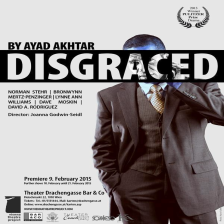

In [4]:
print(mvsa_single_multimodal_labels[23])
print(mvsa_single_texts[23])
tf.keras.utils.array_to_img(mvsa_single_images[23])

# Bert

In [5]:
MAX_LENGTH = 280 # as in twitter word limit

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict = True)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# bert_model.eval() # (evaluation mode is default) put model in evaluation model, turn of regularization in training

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def bert_embed_sentence(text, tokenizer=bert_tokenizer, model=bert_model):
    inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH, padding='max_length')

    with torch.no_grad():
        outputs = model(**inputs, )
        last_hidden_states = outputs.hidden_states[-1]
        bert_embeddings = torch.squeeze(last_hidden_states, dim=0).numpy()
    
    return bert_embeddings

In [8]:
def bert_embed_data(data):
    embedded_data = np.array([])
    
    for line in tqdm(data):
        bert_embeddings = bert_embed_sentence(line)
        if embedded_data.shape[0] == 0:
            embedded_data = np.array([bert_embeddings])#np.empty((0, embedded_line.shape[0]), 'float32')
        else:
            embedded_data = np.concatenate((embedded_data, [bert_embeddings]))
            
    return embedded_data

# VGG-16

In [9]:
vgg16 = VGG16(input_shape=mvsa_single_images.shape[1:])
vgg16.trainable = False # Freeze pre-trained layers
model_vgg16 = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output) # output of last hidden layer

2022-06-17 13:09:13.937927: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 5s 0us/step


# VGG-19

In [10]:
vgg19 = VGG19(input_shape=mvsa_single_images.shape[1:])
vgg19.trainable = False # Freeze pre-trained layers
model_vgg19 = Model(inputs=vgg19.input, outputs=vgg19.layers[-2].output) # output of last hidden layer

574726144/574710816 [==============================] - 9s 0us/step


# Extracting features

In [11]:
print('MVSA-Single: Extracting bert features of texts')
mvsa_single_texts_bert = bert_embed_data(mvsa_single_texts)

MVSA-Single: Extracting bert features of texts


100%|██████████| 4316/4316 [1:32:48<00:00,  1.29s/it]


In [12]:
print('MVSA-Single: Extracting VGG-16 features (last layer) of images')
mvsa_single_images_vgg16 = model_vgg16.predict(mvsa_single_images, verbose=1)

MVSA-Single: Extracting VGG-16 features (last layer) of images


2022-06-17 14:42:22.986033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


135/135 [==============================] - 1145s 8s/step


In [13]:
print('MVSA-Single: Extracting VGG-19 features (last layer) of images')
mvsa_single_images_vgg19 = model_vgg19.predict(mvsa_single_images, verbose=1)

MVSA-Single: Extracting VGG-19 features (last layer) of images
135/135 [==============================] - 1446s 11s/step


In [14]:
with h5py.File('mvsa-single-bert-vgg.hdf5', 'w') as f:
    f.create_dataset('bert-base', data = mvsa_single_texts_bert)
    f.create_dataset('vgg-16', data = mvsa_single_images_vgg16)
    f.create_dataset('vgg-19', data = mvsa_single_images_vgg19)

In [15]:
def load_data(path):
    read_file = h5py.File(path, 'r')
    text_features = read_file['bert-base'][:]
    image_features_16 = read_file['vgg-16'][:]
    image_features_19 = read_file['vgg-19'][:]

    return text_features, image_features_16, image_features_19

In [16]:
mvsa_single_texts_bert_loaded, mvsa_single_images_vgg16_loaded, mvsa_single_images_vgg19_loaded = load_data('mvsa-single-bert-vgg.hdf5')

In [17]:
print((mvsa_single_texts_bert_loaded == mvsa_single_texts_bert).all())
print((mvsa_single_images_vgg16_loaded == mvsa_single_images_vgg16).all())
print((mvsa_single_images_vgg19_loaded == mvsa_single_images_vgg19).all())

True
True
True


# MultiSentiNet: A Deep Semantic Network for Multimodal Sentiment Analysis

In [18]:
# class Attention_input2(Layer):
#     def __init__(self,
#                  W_regularizer=None, u_regularizer=None, b_regularizer=None,
#                  W_constraint=None, u_constraint=None, b_constraint=None,
#                  Wo_regularizer=None,
#                  Wo_constraint=None,
#                  Ws_regularizer=None,
#                  Ws_constraint=None,
#                  bias=True, **kwargs):

#         self.supports_masking = True
#         self.init = initializers.get('glorot_uniform')

#         self.W_regularizer = regularizers.get(W_regularizer)
#         self.Wo_regularizer = regularizers.get(Wo_regularizer)
#         self.Ws_regularizer = regularizers.get(Ws_regularizer)

#         self.u_regularizer = regularizers.get(u_regularizer)
#         self.b_regularizer = regularizers.get(b_regularizer)

#         self.W_constraint = constraints.get(W_constraint)
#         self.Wo_constraint = constraints.get(Wo_constraint)
#         self.Ws_constraint = constraints.get(Ws_constraint)

#         self.u_constraint = constraints.get(u_constraint)
#         self.b_constraint = constraints.get(b_constraint)

#         self.bias = bias
#         super(Attention_input2, self).__init__(**kwargs)

#     def build(self, input_shape):
#         shape1 = input_shape[0]
#         shape2 = input_shape[1]
#         shape3 = input_shape[1]

#         assert len(shape1) == 3

#         self.W = self.add_weight(shape=(shape1[-1], shape1[-1],),
#                                  initializer=self.init,
#                                  name='{}_W'.format(self.name),
#                                  regularizer=self.W_regularizer,
#                                  constraint=self.W_constraint)


#         self.Wo = self.add_weight(shape=(shape2[-1],shape2[-1], ),
#                                  initializer=self.init,
#                                  name='{}_Wo'.format(self.name),
#                                  regularizer=self.Wo_regularizer,
#                                  constraint=self.Wo_constraint)

#         self.Ws = self.add_weight(shape=(shape3[-1],shape3[-1], ),
#                                  initializer=self.init,
#                                  name='{}_Ws'.format(self.name),
#                                  regularizer=self.Ws_regularizer,
#                                  constraint=self.Ws_constraint)

#         if self.bias:
#             self.b = self.add_weight(shape=(shape1[-1],),
#                                      initializer='zero',
#                                      name='{}_b'.format(self.name),
#                                      regularizer=self.b_regularizer,
#                                      constraint=self.b_constraint)

#         self.u = self.add_weight(shape=(shape1[-1],),
#                                  initializer=self.init,
#                                  name='{}_u'.format(self.name),
#                                  regularizer=self.u_regularizer,
#                                  constraint=self.u_constraint)

#         super(Attention_input2, self).build(input_shape)

#     def compute_mask(self, input, input_mask=None):
#         # do not pass the mask to the next layers
#         return None

#     def call(self, input, mask=None):
#         x = input[0]
#         o = input[1]
#         s = input[2]

#         uit_x = K.dot(x, self.W)
#         uit_o = K.dot(o, self.Wo)
#         uit_s = K.dot(s, self.Ws)

#         uit = uit_x + uit_o + uit_s

#         if self.bias:
#             uit += self.b

#         uit = K.tanh(uit)
#         ait = K.dot(uit, self.u)

#         a = K.exp(ait)

#         a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
#         a = K.expand_dims(a)
#         weighted_input = x * a
#         return K.sum(weighted_input, axis=1)

#     def get_output_shape_for(self, input_shape):
#         shape1 = input_shape[0]
#         return shape1[0], shape1[-1]

In [19]:
# MAX_SEQUENCE_LENGTH = 140 # as in twitter post word limit
# MAX_NB_WORDS = 10000
# EMBEDDING_DIM = 200
# VALIDATION_SPLIT = 0.1
# NB_EPOCH = 100
# NB_CLASS = 3
# DIM_HIDDEN = 128
# DIM_LSTM = 128

In [20]:
# # e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
# def split_data(data, validation_split):
#     nb_validation_samples = int(validation_split * data.shape[0])
#     data_train = data[:-(nb_validation_samples * 2)]
#     data_val = data[-(nb_validation_samples * 2):-(nb_validation_samples)]
#     data_test = data[-nb_validation_samples:]
    
#     return data_train, data_val, data_test

In [21]:
# def dp_txt(txt):
#     # nonEnglish_regex = re.compile('[^a-zA-Z0-9\\?\\!\\,\\.@#\\+\\-=\\*\'\"><&\\$%\\(\\)\\[\\]:;]+')
#     hashtag_pattern = re.compile('#[a-zA-Z0-9]+')
#     at_pattern = re.compile('@[a-zA-Z0-9]+')
#     http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
#     txt = txt.strip()
#     txt_hashtag = re.sub(hashtag_pattern, '', txt)
#     txt_nonat = re.sub(at_pattern, '', txt_hashtag)
#     txt_nonhttp = re.sub(http_pattern, '', txt_nonat)
#     txt = txt_nonhttp
#     return txt

In [22]:
# new_texts = []
# for idx in range(len(mvsa_single_texts[:10])):
#     text = mvsa_single_texts[idx]
#     text = dp_txt(str(text))
#     new_texts.append(text)
# texts = new_texts

# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)
# word_index = tokenizer.word_index
# text_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


In [23]:
# le = preprocessing.LabelEncoder()
# le.fit_transform(mvsa_single_labels)
# labels = le.transform(mvsa_single_labels)
# labels = to_categorical(np.asarray(labels))

In [24]:
# text_train, text_val, text_test = split_data(text_data[:10], VALIDATION_SPLIT)
# label_train,label_val, label_test = split_data(labels[:10], VALIDATION_SPLIT)
# # image_train, image_val, image_test = split_data(mvsa_single_images, VALIDATION_SPLIT)
# scene_train,scene_val,scene_test = split_data(vgg_features,VALIDATION_SPLIT)
# object_train,object_val,object_test = split_data(vgg_features,VALIDATION_SPLIT)

# text_shape = text_train.shape[1:]
# scene_shape = scene_train.shape[1:]
# object_shape = object_train.shape[1:]

In [25]:
# embeddings_index = {}
# f = open('../input/glovetwitter27b100d/glove.twitter.27B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[2]
#     coefs = np.asarray(values[1], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# nb_words = min(MAX_NB_WORDS, len(word_index))
# embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if i > MAX_NB_WORDS:
#         continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# embedding_layer = Embedding(nb_words + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)

In [26]:
# checkpoint = ModelCheckpoint('./model_checkpoint/{}.hdf5'.format('MultiSentiNet'), save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)

In [27]:
# # Image Sence
# scene_input = Input(shape=scene_shape, dtype='float32')
# img_scene = Dense(DIM_HIDDEN, activation='relu')(scene_input)
# img_scene_encoder = RepeatVector(text_shape[0], name='scene-repeat')(img_scene)

# # Image Object
# object_input = Input(shape=object_shape, dtype='float32')
# img_object = Dense(DIM_HIDDEN, activation='relu')(object_input)
# img_object_encoder = RepeatVector(text_shape[0], name='object-repeat')(img_object)

In [28]:
# # Text
# txt_input = Input(shape=text_shape, dtype='float32')
# txt = embedding_layer(txt_input)
# txt_hidden = (LSTM(DIM_HIDDEN, return_sequences=True, name='tweet-lstm'))(txt)
# txt_att = Attention_input2(name='att_so')([txt_hidden, img_object_encoder, img_scene_encoder])

In [29]:
# def average_LSTM_sentence(word_embedddings):
#     embedding_sum = [np.zeros(word_embedddings.shape[1:])]
    
#     for i in word_embedddings:
#         embedding_sum += i
        
#     return embedding_sum / word_embeddings.shape[1]

In [30]:
# # Merge
# # img_txt = merge([img_scene, img_object, txt_att], mode='concat')
# img_txt = merge([image_hidden, txt_hidden, txt_hidden], mode='concat')
# img_txt = Dense(DIM_HIDDEN, activation='relu')(img_txt)
# img_txt_loss = Dense(NB_CLASS, activation='softmax', name='main_output') (img_txt)

# SFNN Semantic feature fusion neural network for mutimodal sentiment analysis

In [31]:
# NUM_HIDDEN = 128
# NUM_CLASSES = len(set(mvsa_single_labels)) # =3
# EPOCHS = 100

In [32]:
# le = preprocessing.LabelEncoder()
# le.fit_transform(mvsa_single_labels)
# tokenized_labels = le.transform(mvsa_single_labels)
# labels = to_categorical(np.asarray(tokenized_labels))

In [33]:
# text = mvsa_single_texts[0]
# text_data = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
# labels = to_categorical(np.asarray(tokenized_labels))

In [34]:
# # e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
# def split_data(data, validation_split):
#     nb_validation_samples = int(validation_split * data.shape[0])
#     data_train = data[:-(nb_validation_samples * 2)]
#     data_val = data[-(nb_validation_samples * 2):-(nb_validation_samples)]
#     data_test = data[-nb_validation_samples:]
    
#     return data_train, data_val, data_test

In [35]:
# VALIDATION_SPLIT = 0.1

# text_train, text_val, text_test = split_data(bert_features, VALIDATION_SPLIT)
# label_train,label_val, label_test = split_data(labels, VALIDATION_SPLIT)
# image_train, image_val, image_test = split_data(vgg_features, VALIDATION_SPLIT)

# print('Number of train data:', text_train.shape[0])
# print('Number of validation data:', text_val.shape[0])
# print('Number of test data:', text_test.shape[0])

# SFNN Model

In [36]:
# image_input = Input(shape=vgg_features.shape[1:])
# vgg_attention = tf.keras.layers.Attention() ([image_input, image_input])
# image_reshape = tf.keras.layers.Reshape((1, vgg_attention.shape[1]), input_shape=(vgg_attention.shape[1],)) (vgg_attention)
# image_bi_gru = Bidirectional(GRU(NUM_HIDDEN, return_sequences=True)) (image_reshape)
# semantic_attention = tf.keras.layers.Attention() ([image_bi_gru, image_bi_gru])

In [37]:
# text_input = Input(shape=bert_features.shape[1:])
# text_bi_gru = Bidirectional(GRU(NUM_HIDDEN, return_sequences=True)) (text_input)
# text_attention = tf.keras.layers.Attention() ([text_bi_gru, text_bi_gru])

In [38]:
# text_image_concat = tf.keras.layers.Concatenate(axis=1)([semantic_attention, text_attention])
# # TODO: PCA layer
# # pca = PCA()
# # reduced = pca.fit_transform(text_image_concat.output)
# flatten = Flatten() (text_image_concat)
# dense_output = Dense(NUM_CLASSES, activation='softmax') (flatten)

In [39]:
# sfnn_model = Model([image_input, text_input], dense_output)
# sfnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# sfnn_model.summary()

In [40]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1) # reduce learning rate by 0.1 (factor)

# checkpoint_sfnn = ModelCheckpoint('./model_checkpoint/{}.h5'.format('sfnn'), save_best_only=True, verbose=1)

In [41]:
# sfnn_model.fit([image_train, text_train], label_train, epochs=EPOCHS, 
#                validation_data=([image_val, text_val], label_val), 
#                callbacks=[checkpoint_sfnn, reduce_lr])
# sfnn_model = load_model('./model_checkpoint/{}.h5'.format('sfnn'))

In [42]:
# sfnn_model.evaluate([image_test, text_test], label_test)

# Drafts

In [43]:
# np.savez('./mvsa-single-texts-bert', mvsa_single_texts_bert)
# npzfile = np.load('./mvsa-single-texts-bert.npz')
# mvsa_single_texts_bert_loaded = npzfile['arr_0']

In [44]:
## OLD LOAD FILES WITH NUMPY

# def read_text_file(path, multi_line=False):
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
#     return open(path, 'r', encoding='latin-1').read()

# mvsa_single_texts = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-texts.txt', multi_line=True)
# mvsa_single_images = np.load('../input/mvsa-data/mvsa-single-data/mvsa-single-images.npy')
# mvsa_single_labels = read_text_file('../input/mvsa-data/mvsa-single-data/mvsa-single-labels.txt', multi_line=True)

In [45]:
#### OLD BERT SENTENCE EMBED

# # get all token embeddings with padding
# def bert_embed(text, tokenizer=bert_tokenizer, model=bert_model):
#     marked_text = "[CLS] " + text + " [SEP]"
#     tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Map the token strings to their vocabulary indeces.
#     padded = pad_sequences([indexed_tokens], maxlen=MAX_LENGTH, padding='post', truncating='post')[0]
#     segments_ids = [1] * MAX_LENGTH
#     tokens_tensor = torch.tensor(np.array([padded]))
#     segments_tensor = torch.tensor(np.array([segments_ids]))

#     with torch.no_grad():
#         outputs = model(tokens_tensor, segments_tensor)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        
# #         return outputs
# #         print(outputs)
#         hidden_states = outputs[2]
#         last_hidden_states = hidden_states[-1] # get embeddings of every word at last layer
#         print(last_hidden_states)

#         bert_embeddings = torch.squeeze(last_hidden_states, dim=0).numpy()
#     return bert_embeddings

# # text = mvsa_single_texts[0]
# # bert_embed(text).shape

In [46]:
# bert_embeddings.shape
# outputs[0]
# last_hidden_states = outputs.last_hidden_state

# token_vecs = hidden_states[-2][0]

# # Calculate the average of all 22 token vectors.
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [47]:
# EMB_DIM = 100
# MAX_WORDS = 1000
# if max_words is not None: 
#     VOCAB_LEN = max_words 
# else:
#     VOCAB_LEN = len(word_index)+1
# embedding_matrix = np.zeros((VOCAB_LEN, EMB_DIM))
# oov_count = 0
# oov_words = []
# for word, idx in word_index.items():
#     if idx < VOCAB_LEN:
#         embedding_vector = embedding_vectors.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[idx] = embedding_vector

In [48]:
# text = mvsa_single_texts[0]
# inputs = bert_tokenizer(text, return_tensors="pt")
# outputs = bert_model(**inputs)
# last_hidden_states = outputs.last_hidden_state
# bert_embeddings = torch.squeeze(last_hidden_states, dim=0)

In [49]:
# padded = pad_sequences([inputs['input_ids'][0]], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')[0]
# inputs['input_ids'] = torch.tensor(padded).to(torch.long)
# mask = np.where(padded == 0, 0, 1)
# inputs['attention_mask'] = torch.tensor(mask)
# token_type_ids = [0] * len(padded)
# inputs['token_type_ids'] = torch.tensor(token_type_ids)

In [50]:
# encoding = bert_tokenizer.encode_plus(mvsa_single_texts[0], add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors="pt")
# tokenized_text = encoding['input_ids'][0]
# attention_mask = encoding["attention_mask"][0]